[youtube](https://youtu.be/TW_xzxCqIw8)
[github](https://github.com/SungchulLee/financial_math/tree/master/implied_volatility)
[ppt](https://github.com/SungchulLee/financial_math/blob/master/%E1%84%8B%E1%85%B5%E1%86%B7%E1%84%91%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A1%E1%84%8B%E1%85%B5%E1%84%83%E1%85%B3%20%E1%84%87%E1%85%A9%E1%86%AF.pptx)
[Python for Finance](https://github.com/yhilpisch/py4fi)

$$
C(S,K,\tau,r,\sigma)=SN(d_1)-Ke^{-r\tau}N(d_2)
$$
$$
d_1=\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)\tau}{\sigma\sqrt{\tau}}
$$
$$
d_2=\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)\tau}{\sigma\sqrt{\tau}}
$$

In [1]:
def C(S, K, tau, r, sigma):
    import numpy as np
    import scipy.stats as stats
    d1 = (np.log(S/K) + (r+sigma**2/2)*tau) / (sigma*np.sqrt(tau))
    d2 = (np.log(S/K) + (r-sigma**2/2)*tau) / (sigma*np.sqrt(tau))
    N = stats.norm().cdf 
    return S*N(d1) - K*np.exp(-r*tau)*N(d2)

In [2]:
def bsm_call_value(S0, K, T, r, sigma):
    from math import log, sqrt, exp
    from scipy import stats
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0)
            - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value

$$
\mbox{vega}_C(S,K,\tau,r,\sigma)=\frac{\partial C}{\partial\sigma}=SN'(d_1)\sqrt{\tau}
$$

In [3]:
def vega_C(S, K, tau, r, sigma):
    import numpy as np
    import scipy.stats as stats
    d1 = (np.log(S/K) + (r+sigma**2/2)*tau) / (sigma*np.sqrt(tau))
    #d2 = (np.log(S/K) + (r-sigma**2/2)*tau) / (sigma*np.sqrt(tau))
    N_prime = stats.norm().pdf 
    return S*N_prime(d1)*np.sqrt(tau)

In [4]:
def bsm_vega(S0, K, T, r, sigma):
    from math import log, sqrt
    from scipy import stats
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

$$
\sigma^{\tiny\mbox{imp}}_{n+1}=\sigma^{\tiny\mbox{imp}}_n-\frac{C(\sigma^{\tiny\mbox{imp}}_n)-C_{\tiny\mbox{observed}}}{\mbox{vega}_C(\sigma^{\tiny\mbox{imp}}_n)}
$$

In [5]:
def implied_vol_C(S, K, tau, r, sigma_0, C_observed, 
                  max_iter=100, tol=1e-10, rel_tol=1e-10):
    import numpy as np
    for i in range(max_iter):
        price_gap = C(S, K, tau, r, sigma_0) - C_observed 
        vega = vega_C(S, K, tau, r, sigma_0)
        delta_sigma = price_gap / vega
        sigma_0 -= delta_sigma
        if np.absolute(price_gap).max() < tol:
            return sigma_0
        if np.absolute(delta_sigma).max() < rel_tol:
            return sigma_0 
    return sigma_0

In [6]:
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0)
                        / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

/Users/sungchullee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


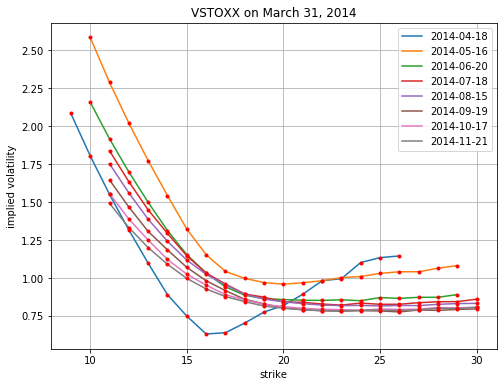

In [42]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

h5 = pd.HDFStore('./data/vstoxx_data_31032014.h5', 'r')
futures = h5['futures_data']  # VSTOXX futures data
options = h5['options_data']  # VSTOXX call option data
h5.close()

futures.DATE = futures.DATE.apply(lambda x: dt.datetime.fromtimestamp(x/1e9))
futures.MATURITY = futures.MATURITY.apply(lambda x: dt.datetime.fromtimestamp(x/1e9))
options.DATE = options.DATE.apply(lambda x: dt.datetime.fromtimestamp(x/1e9))
options.MATURITY = options.MATURITY.apply(lambda x: dt.datetime.fromtimestamp(x/1e9))

options['IMP_VOL'] = 0.0

tol = 0.5  # tolerance level for moneyness
for option in options.index:  # iterating over all option quotes
    maturity = options.loc[option, 'MATURITY']
    K = options.loc[option, 'STRIKE']
    future = futures[futures.MATURITY == maturity]['PRICE'].values[0]
    if future*(1-tol) < K < future*(1+tol):
        S = 17.6639  # VSTOXX value 
        K = options.loc[option, 'STRIKE']
        tau = options.loc[option, 'TTM']
        r = 0.01  # short rate
        sigma_0 = 2.
        C_observed = options.loc[option, 'PRICE'] 
        options.loc[option, 'IMP_VOL'] = implied_vol_C(S, K, tau, r, sigma_0, C_observed)
        
plot_data = options[options.IMP_VOL > 0]
maturities = sorted(set(options.MATURITY))
        
plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[options.MATURITY == maturity]
    plt.plot(data.STRIKE, data.IMP_VOL, 
             label=maturity.date(), lw=1.5)
    plt.plot(data.STRIKE, data.IMP_VOL, 'r.', label='')
plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied volatility')
plt.title('VSTOXX on March 31, 2014')
plt.legend()
plt.show()